This notebook contains my replication of [this](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) blog post by [Jake VanderPlan](http://vanderplas.com/) on using data from bicycle traffic across Seattle's Fremont Bridge to learn about commuting patterns.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

from seattlecycling.data import get_fremont_data

In [11]:
# Load data

start = '1 Oct 2012'
end = '30 Jun 2015'

data = get_fremont_data()
data = data.loc[start:end]
data.head(3)

,total,west,east
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0


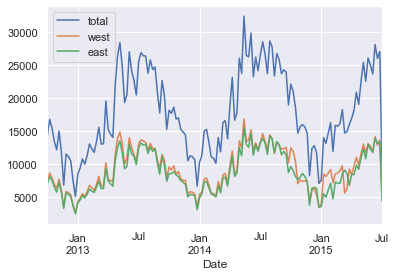

In [12]:
# A first look at the data

data.resample('w').sum().plot();

In [13]:
pivoted = data.pivot_table(['west', 'east'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

east                                     ... west                 \
Date         0  1  2  3  4   5   6    7    8    9   ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104  ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94  ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81  ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55  ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36  ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [14]:
# Put raw values in a matrix

X = pivoted.values
X.shape

(1001, 48)

# Visualising the data

In [20]:
# Use PCA to reduce dimensionality (keep 90 percent of the variance)

from sklearn.decomposition import PCA
Xpca = PCA(.9).fit_transform(X)
Xpca.shape

(1001, 2)

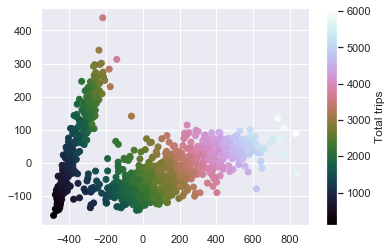

In [36]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], 
            c=total_trips, 
            cmap='cubehelix')
plt.colorbar(label='Total trips');

What can we learn from this graph? We can see that the days fall into two quite distinct cluster, one with a higher number of trips and one with a lower number of trips, that the number of trips increases along the length of each projected cluster (i.e. as we move away from the origin), and that close to the origin, the groups are less distinguishable. Overall, we can see that there are, in effect, two types of days for Seattle cyclists. This is indeed pretty cool.